# Summary
- 0.Import
- 1.Load model and dataset
- 2.Calculate conductance and LCR
    - 2.1 Conductance
    - 2.2 LCR
- 3.Training an error detector
    - 3.1 Preprocess conductance
    - 3.2 Training with conductance
    - 3.3 Training with LCR
    - 3.4 Training with conductance & LCR
    - 3.5 Overview with the 3 training setups
- 4.Other architectures for error detector
    - 4.1 Random forest
    - 4.2 LDA & QDA

## 0. Import

In [1]:
%reload_ext autoreload
%autoreload

In [4]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras import backend as K
from keras.models import Model, Sequential
from keras.datasets import cifar10
import numpy as np
import os
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from keras.preprocessing import image

In [12]:
from scripts.utils import *

## 1. Loading the dataset and model:

In [6]:
num_class = 10

index_to_label = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
label_to_index = {u:v for v,u in index_to_label.items()}
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = (np.zeros((1,32,32,3)), np.zeros((1,1))), (np.zeros((1,32,32,3)), np.zeros((1,1)))

input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

x_train shape: (1, 32, 32, 3)
1 train samples
1 test samples
y_train shape: (1, 1)


In [7]:
model = resnet_v1(input_shape = input_shape, depth = 3*6+2)
model.load_weights('cifar10resnet_weights.h5')

In [ ]:
test_pred = np.argmax(model.predict(x_test), axis = 1)

## 2. Calculate conductance and label change rate (LCR)

### 2.1 Calculate conductance

It corresponds to section 3.1 of the paper (https://arxiv.org/pdf/1910.00387.pdf). Here, we compute conductance metric for each prediction of the image training and test set.

In [8]:
train_pred = np.argmax(model.predict(x_train), axis = 1)
train_label = np.argmax(y_train, axis = 1)

In [9]:
w = train_pred != train_label
wrongs_index = np.arange(len(train_pred))[w]
r = train_pred == train_label
rights_index = np.arange(len(train_pred))[r]

In [ ]:
cond_wrongs, originIndex_wrongs = calculate_cond(model, x_train, train_pred, wrongs_index)
cond_rights, originIndex_rights = calculate_cond(model, x_train, train_pred, rights_index)

In [ ]:
cond_test, originIndex_test = calculate_cond(model, x_test, test_pred, np.arange(len(test_pred)))

In [ ]:
#reorder x_test and y_test following the same order conductance are organized
#originIndex_test = pickle.load(open('test_index.p', 'rb'))
L = []
for c in range(num_class):
    L.append(originIndex_test[c])
#the first values of L are index of x_test whose element are predicted as class 0, then class 1 ... 
L = np.concatenate(L, axis = 0)
x_test = x_test[L]
y_test = y_test[L]
test_pred = test_pred[L]

rnd_split = np.arange(len(x_test))
np.random.shuffle(rnd_split)
#pickle.dump(rnd_split, open('rnd_split.p', 'wb'))
#rnd_split = pickle.load(open('rnd_split.p', 'rb'))

#the original test set is evenly divided into a new test set and validation set
x_val = x_test[rnd_split[:5000]]
y_val = y_test[rnd_split[:5000]]
x_test = x_test[rnd_split[5000:]]
y_test = y_test[rnd_split[5000:]]
pred_val = test_pred[rnd_split[:5000]]
pred_test = test_pred[rnd_split[5000:]]

### 2.2 Calculate LCR

In [ ]:
#load the modified version of the model
model_mutants = pickle.load(open('mutants_NAI_0.01.p', 'rb'))

In [14]:
LCRW = calculate_LCR(model, x_train, originIndex_wrongs, model_mutants)

In [ ]:
LCRR = calculate_LCR(model, x_train, originIndex_rights, model_mutants)

In [ ]:
LCR_test = calculate_LCR(model, x_test, originIndex_test, model_mutants)

In [ ]:
LCR_train = np.concatenate((LCRW, LCRR), axis = 0)
#rnd_split is the same that was used to split the orginal test set of images
LCR_test = LCR_test.reshape((-1,1))
LCR_val = LCR_test[rnd_split[:5000]]
LCR_test = LCR_test[rnd_split[5000:]]

## 3. Training the error predictor which is a neural network

### 3.1 Preprocess conductance

In [12]:
#get all conv layer in the network
#for resnet, only the output of resBlocks are considered (skip connection + normal connection)
convLayers = []
for i in range(len(model.layers)):
    if "add" in model.layers[i].name:
        convLayers.append(model.layers[i+1])

#select only conductance of the last conv layer if concat = 0
layers = [len(convLayers)-i-1 for i in range(len(convLayers))]
concat = 0
cond_wrongs = process_cond(layers, cond_wrongs, concat)
cond_rights = process_cond(layers, cond_rights, concat)

In [13]:
#training set
trainD = np.concatenate((cond_wrongs,cond_rights), axis = 0)

#normalize cond values
mins = np.min(trainD, axis = 0)
maxs = np.max(trainD, axis = 0)
avgs = np.mean(trainD, axis = 0)
trainD = (trainD - avgs) / (maxs - mins)

#set label for conductances
y_wrongs = np.ones(len(cond_wrongs))
y_rights = np.zeros(len(cond_rights))
trainL = np.concatenate((y_wrongs,y_rights), axis = 0)

In [15]:
testD = process_cond(layers, cond_test, concat)
testD = (testD-avgs)/(maxs-mins)

In [16]:
#rnd_split is the same that was used to split the orginal test set of images
valD = testD[rnd_split[:5000]]
testD = testD[rnd_split[5000:]]

In [17]:
label_val = np.argmax(y_val, axis =1)
valL = pred_val != label_val

### 3.2 Training with only conductance

It corresponds to section 4 of the paper (https://arxiv.org/pdf/1910.00387.pdf). Here we train a neural network to classify previous conductances into conductance of wrong or correct prediction.

In [19]:
#create the error detector
classifier = error_detector(trainD.shape[1])

In [19]:
#train the error detector and assess its quality with are under the ROC curve
#not using accuracy here because the dataset is unbalanced
roc_call = roc_callback(training_data=(trainD, trainL),validation_data=(valD, valL))
classifier.fit(trainD, trainL, batch_size = 50, validation_data = (valD, valL), epochs = 20, callbacks = [roc_call])

Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 107us/step - loss: 0.2500 - acc: 0.8979 - val_loss: 0.2874 - val_acc: 0.8800
roc-auc: 0.93566 - roc-auc_val: 0.90405                                                                                                    
Epoch 2/20
50000/50000 [==============================] - 5s 98us/step - loss: 0.2142 - acc: 0.9112 - val_loss: 0.2808 - val_acc: 0.8814
roc-auc: 0.9423 - roc-auc_val: 0.91039                                                                                                    
Epoch 3/20
50000/50000 [==============================] - 5s 98us/step - loss: 0.2062 - acc: 0.9145 - val_loss: 0.2764 - val_acc: 0.8866
roc-auc: 0.94561 - roc-auc_val: 0.91301                                                                                                    
Epoch 4/20
50000/50000 [==============================] - 5s 98us/step - loss: 0.2007 - acc: 0.9172 - val_loss: 0.2813 -

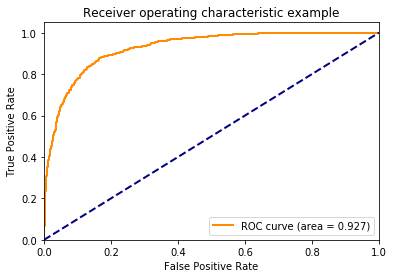

accuracy 0.8508 mean recall 0.85106271912189 right recall 0.8514619883040936 wrong recall 0.8506634499396863
0.134 0.9271064271051573


In [21]:
#assess the performance of the error detector on the validation set 
#and plot its ROC curve
val_res = classifier.predict(valD)
cond_threshs, cond_ind, cond_auroc = find_opti_thresh(valL, val_res, plot = True)

#choosing the threhold that would optimize the recall on classes of wrong and correct predictions
cond_thresh = cond_threshs[cond_ind-38]
cond_thresh = 1.34e-1

#print the accuracy on the validation set using that threshold
print('threshold', cond_thresh)
print("auroc", cond_auroc)
report(val_res, valL, cond_thresh, True)

In [22]:
#creating the label for conductance of the test set 
label_test = np.argmax(y_test, axis =1)
testL = pred_test != label_test

In [23]:
#test the performance of the error detector on the test set 
#with the threshold chosen from the validation set
test_res = classifier.predict(testD)
report(test_res, testL, cond_thresh, True)

accuracy 0.8522 mean recall 0.8564574119666857 right recall 0.8631346578366446 wrong recall 0.8497801660967269


In [33]:
#classifier.save('cond_error_detector.h5')

In [20]:
#classifier.load_weights('cond_error_detector.h5')

### 3.3 Training with only LCR

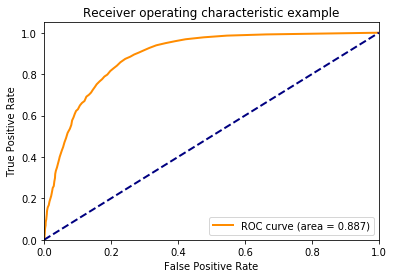

accuracy 0.8044 mean recall 0.808687984537137 right recall 0.8152046783625732 wrong recall 0.8021712907117008
0.169 0.8872483581289371


In [26]:
#test the performance of LCR to distinguish wrong and correct predictions and plot the ROC curve
lcr_threshs, lcr_ind, lcr_auroc = find_opti_thresh(valL, LCR_val, plot = True)

#find the optimal threshold
lcr_thresh = lcr_threshs[lcr_ind-4]
lcr_thresh = 0.169

#see result with that treshold on the validation set
print('threshold', lcr_thresh)
print("auroc", lcr_auroc)
report(LCR_val, valL, lcr_thresh, True)

In [27]:
report(LCR_test, testL, lcr_thresh, True)

accuracy 0.8124 mean recall 0.8235586239918213 right recall 0.8410596026490066 wrong recall 0.8060576453346361


### 3.4 Training with both LCR and conductance

In [28]:
#combining the output of the binary classifier trained on conductance with LCR
train_res = classifier.predict(trainD)
data = np.concatenate((LCR_train.reshape((-1,1)), train_res), axis = 1)
data_val = np.concatenate((LCR_val.reshape((-1,1)), val_res), axis = 1)
data_test = np.concatenate((LCR_test.reshape((-1,1)), test_res), axis = 1)

In [29]:
#building the unified classifier that take as input LCR and conductance
nn = Sequential()    
nn.add(Dense(10, input_shape = (data.shape[1],), activation = 'relu'))
nn.add(Dense(10, activation = 'relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation = 'sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
nn.compile(loss = 'binary_crossentropy', optimizer=opt,metrics=None)

In [69]:
#training with focus on the area under the ROC
roc_call = roc_callback(training_data=(data, trainL),validation_data=(data_val, valL))
history = nn.fit(data, trainL, validation_data = (data_val, valL), batch_size = 100, epochs = 3, callbacks = [roc_call])

Train on 50000 samples, validate on 5000 samples
Epoch 1/3
50000/50000 [==============================] - 3s 56us/step - loss: 0.3797 - val_loss: 0.2587
roc-auc: 0.96183 - roc-auc_val: 0.93069                                                                                                    
Epoch 2/3
50000/50000 [==============================] - 2s 45us/step - loss: 0.2158 - val_loss: 0.2595
roc-auc: 0.96191 - roc-auc_val: 0.93272                                                                                                    
Epoch 3/3
50000/50000 [==============================] - 2s 46us/step - loss: 0.2087 - val_loss: 0.2501
roc-auc: 0.96166 - roc-auc_val: 0.93269                                                                                                    


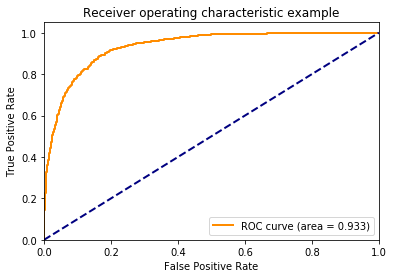

accuracy 0.8558 mean recall 0.855935072905424 right recall 0.856140350877193 wrong recall 0.855729794933655
0.0995 0.932694784810841


In [32]:
#performance assessment
nn_val_res = nn.predict(data_val)
both_threshs, both_ind, both_auroc = find_opti_thresh(valL, nn_val_res, plot = True)

#finding a threshold
both_thresh = both_threshs[both_ind-34]
both_thresh = 9.95e-2

#see result on the validation set
print('threshold', both_thresh)
print("auroc", both_auroc)
report(nn_val_res, valL, both_thresh, True)

In [33]:
#see result on the test set with the chosen threshold
nn_test_res = nn.predict(data_test)
report(nn_test_res, testL, both_thresh, True)

accuracy 0.8624 mean recall 0.8652645178266585 right recall 0.869757174392936 wrong recall 0.8607718612603811


In [94]:
#nn.save('cond&LCR_error_detector.h5')

In [30]:
#nn.load_weights('cond&LCR_error_detector.h5')

### 3.5 Overview of the error detector performance for all 3 settings of entry data

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
cond_fpr, cond_tpr, cond_threshs = roc_curve(valL, val_res)
lcr_fpr, lcr_tpr, lcr_threshs = roc_curve(valL, LCR_val)
both_fpr, both_tpr, both_threshs = roc_curve(valL, nn_val_res)

In [35]:
both_x, both_y = both_fpr[both_ind-34], both_tpr[both_ind-34]
lcr_x, lcr_y = lcr_fpr[lcr_ind-4], lcr_tpr[lcr_ind-4]
cond_x, cond_y = cond_fpr[cond_ind-34], cond_tpr[cond_ind-38]

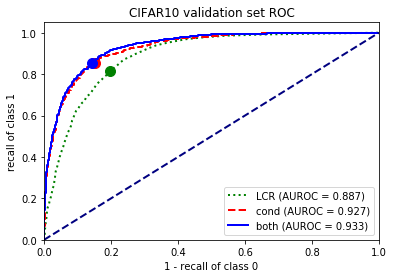

In [38]:
plt.figure()
lw = 2
plt.plot(lcr_fpr, lcr_tpr, ':', color = 'green',
         lw=lw, label='LCR (AUROC = %0.3f)' % lcr_auroc)
plt.plot(lcr_x, lcr_y,marker='o',  markersize=10, color= 'green')
plt.plot(cond_fpr, cond_tpr, '--', color = 'red',
         lw=lw, label='cond (AUROC = %0.3f)' % cond_auroc)
plt.plot(cond_x, cond_y, marker='o',  markersize=10, color= 'red')
plt.plot(both_fpr, both_tpr, color = 'blue',
         lw=lw, label='both (AUROC = %0.3f)' % both_auroc)
plt.plot(both_x, both_y, marker='o',  markersize=10, color= 'blue')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - recall of class 0')
plt.ylabel('recall of class 1')
plt.title('CIFAR10 validation set ROC')
plt.legend(loc="lower right")
plt.savefig('cifar10_roc.pdf', bbox_inches = 'tight')

## 4. Choosing other machine learning classifiers for the error detector

- classifiers are trained with both LCR and conductance

### 4.1 Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators = 100, max_depth=10 ,random_state=0)
clf_RF.fit(data, trainL)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

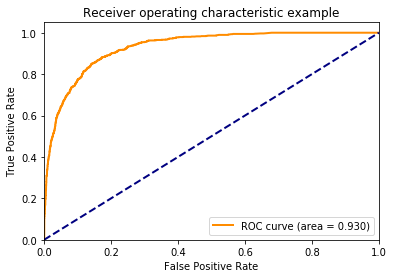

0.125 0.9298962323379821
accuracy 0.8536 mean recall 0.8532156688464224 right recall 0.8526315789473684 wrong recall 0.8537997587454764


In [90]:
rf_val_res = clf_RF.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, rf_val_res, plot = True)
thresh = threshs[ind-45]
thresh = 1.25e-1
print('threshold', thresh)
print("auroc", auroc)
report(rf_val_res, valL, thresh, True)

In [91]:
rf_test_res = clf_RF.predict_proba(data_test)[:,1]
report(rf_test_res, testL, thresh, True)

accuracy 0.8572 mean recall 0.8565024355892594 right recall 0.8554083885209713 wrong recall 0.8575964826575476


### 4.2 LDA & QDA

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf_LDA = LDA()
clf_QDA = QDA()
clf_LDA.fit(data, trainL)
clf_QDA.fit(data, trainL)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

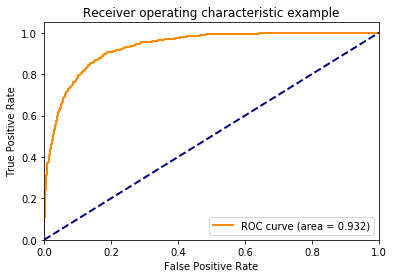

0.00364 0.9316668430223124
accuracy 0.8564 mean recall 0.8562969546907075 right recall 0.856140350877193 wrong recall 0.856453558504222


In [112]:
LDA_val_res = clf_LDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, LDA_val_res, plot = True)
thresh = threshs[ind-73]
thresh = 3.64e-3
print('threshold', thresh)
print("auroc", auroc)
report(LDA_val_res, valL, thresh, True)

In [113]:
LDA_test_res = clf_LDA.predict_proba(data_test)[:,1]
report(LDA_test_res, testL, thresh, True)

accuracy 0.8592 mean recall 0.8603022136524565 right recall 0.8620309050772627 wrong recall 0.8585735222276503


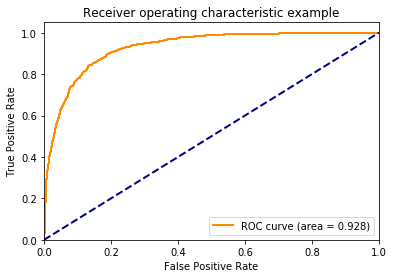

0.0509 <function auc at 0x000002442ACC8488>
accuracy 0.8538 mean recall 0.8538004641680599 right recall 0.8538011695906432 wrong recall 0.8537997587454764


In [119]:
QDA_val_res = clf_QDA.predict_proba(data_val)[:,1]
threshs, ind, auroc = find_opti_thresh(valL, QDA_val_res, plot = True)
thresh = threshs[ind]
thresh = 5.09e-2
print('threshold', thresh)
print("auroc", auroc)
report(QDA_val_res, valL, thresh, True)

In [120]:
QDA_test_res = clf_QDA.predict_proba(data_test)[:,1]
report(QDA_test_res, testL, thresh, True)

accuracy 0.8582 mean recall 0.8528156209862923 right recall 0.8443708609271523 wrong recall 0.8612603810454323
